# Training Humanoid Robots with Crowdsourced Motion Data

This notebook demonstrates the full pipeline from **crowdsourced motion capture data** to **humanoid robot training**.

**Pipeline Overview:**
1. **Data Loading** — Fetch pose data from the live API
2. **Exploration** — Visualize skeletons, keypoint distributions, and data quality
3. **Preprocessing** — Normalize coordinates, compute joint angles and velocities
4. **Visualization** — Animate the 33-point skeleton over time
5. **Model Training** — Behavioral cloning with an LSTM for motion prediction
6. **Robot Mapping** — Map BlazePose keypoints to humanoid robot joint angles
7. **Evaluation** — Compare predicted vs. actual motion trajectories

## 0. Setup & Dependencies

In [1]:
# Install required packages (run once)
!pip install requests numpy pandas matplotlib torch scikit-learn scipy

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory


In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

print("All imports successful!")

All imports successful!


## 1. Data Loading — Fetch from Live API

Our platform provides a REST API for accessing approved motion capture submissions. Each submission contains:
- **Video URL** — WebM recording of the contributor performing the task
- **Pose Data** — Array of frames, each with 33 BlazePose keypoints (x, y, z, confidence)
- **Metadata** — Contributor info, approval status, rating

In [3]:
# === CONFIGURATION ===
# Paste your full API endpoint URL below (from the Developer Integration page)
API_URL = "http://localhost:3000/api/developer/mk_940786628ee849b3bd4bf8fb895d8ccf"

# Fetch data from the API
response = requests.get(API_URL)
data = response.json()

print(f"Endpoint: {data['endpoint']}")
print(f"Task: {data['task']['title']}")
print(f"Description: {data['task']['description']}")
print(f"Total submissions: {data['count']}")

Endpoint: grab-test-data
Task: Darryl
Description: 13123
Total submissions: 1


In [4]:
# Parse submissions into structured format
submissions = data['submissions']

# Show a summary of each submission
for i, sub in enumerate(submissions):
    pose_data = sub.get('poseData', [])
    n_frames = len(pose_data) if pose_data else 0
    rating = sub.get('rating', 'N/A')
    status = sub.get('status', 'unknown')
    print(f"  Submission {i+1}: {n_frames} frames, rating={rating}, status={status}")

  Submission 1: 150 frames, rating=4, status=approved


## 2. Data Exploration

### BlazePose Keypoint Map (33 points)

```
Head:   0=nose, 1-6=eyes, 7-8=ears, 9-10=mouth
Arms:   11-12=shoulders, 13-14=elbows, 15-16=wrists, 17-22=hands
Torso:  11-12=shoulders, 23-24=hips
Legs:   25-26=knees, 27-28=ankles, 29-32=feet
```

In [5]:
# BlazePose keypoint names
KEYPOINT_NAMES = [
    'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
    'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 'mouth_left', 'mouth_right',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky',
    'left_index', 'right_index', 'left_thumb', 'right_thumb',
    'left_hip', 'right_hip', 'left_knee', 'right_knee',
    'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index'
]

# Skeleton connections for visualization
SKELETON_CONNECTIONS = [
    (0, 7), (0, 8),           # nose to ears
    (11, 12),                  # shoulders
    (11, 13), (13, 15),        # left arm
    (12, 14), (14, 16),        # right arm
    (15, 17), (15, 19), (15, 21),  # left hand
    (16, 18), (16, 20), (16, 22),  # right hand
    (11, 23), (12, 24),        # shoulders to hips
    (23, 24),                  # hips
    (23, 25), (25, 27),        # left leg
    (24, 26), (26, 28),        # right leg
    (27, 29), (27, 31),        # left foot
    (28, 30), (28, 32),        # right foot
]

# Robot-relevant keypoints (body joints, excluding face details)
ROBOT_KEYPOINTS = {
    'head': 0,
    'left_shoulder': 11, 'right_shoulder': 12,
    'left_elbow': 13, 'right_elbow': 14,
    'left_wrist': 15, 'right_wrist': 16,
    'left_hip': 23, 'right_hip': 24,
    'left_knee': 25, 'right_knee': 26,
    'left_ankle': 27, 'right_ankle': 28,
}

print(f"Total keypoints: {len(KEYPOINT_NAMES)}")
print(f"Robot-relevant joints: {len(ROBOT_KEYPOINTS)}")

Total keypoints: 33
Robot-relevant joints: 13


In [6]:
def parse_pose_frames(pose_data):
    """Convert raw pose data into a numpy array.
    
    Returns:
        positions: (n_frames, 33, 3) array of x,y,z coordinates
        confidences: (n_frames, 33) array of confidence scores
        timestamps: (n_frames,) array of timestamps
    """
    n_frames = len(pose_data)
    positions = np.zeros((n_frames, 33, 3))
    confidences = np.zeros((n_frames, 33))
    timestamps = np.zeros(n_frames)
    
    for i, frame in enumerate(pose_data):
        timestamps[i] = frame.get('timestamp', 0)
        keypoints = frame.get('keypoints', [])
        for j, kp in enumerate(keypoints[:33]):
            positions[i, j, 0] = kp.get('x', 0)
            positions[i, j, 1] = kp.get('y', 0)
            positions[i, j, 2] = kp.get('z', 0)
            confidences[i, j] = kp.get('score', 0)
    
    return positions, confidences, timestamps

# Parse the first submission as our primary example
sub_idx = 0  # Change this to explore different submissions
pose_data = submissions[sub_idx].get('poseData', [])
positions, confidences, timestamps = parse_pose_frames(pose_data)

print(f"Submission {sub_idx + 1}:")
print(f"  Shape: {positions.shape} (frames, keypoints, xyz)")
print(f"  Duration: {(timestamps[-1] - timestamps[0]) / 1000:.1f}s")
print(f"  Avg FPS: {len(timestamps) / ((timestamps[-1] - timestamps[0]) / 1000):.1f}")
print(f"  Mean confidence: {confidences.mean():.3f}")

Submission 1:
  Shape: (150, 33, 3) (frames, keypoints, xyz)
  Duration: 2.6s
  Avg FPS: 58.0
  Mean confidence: 0.164


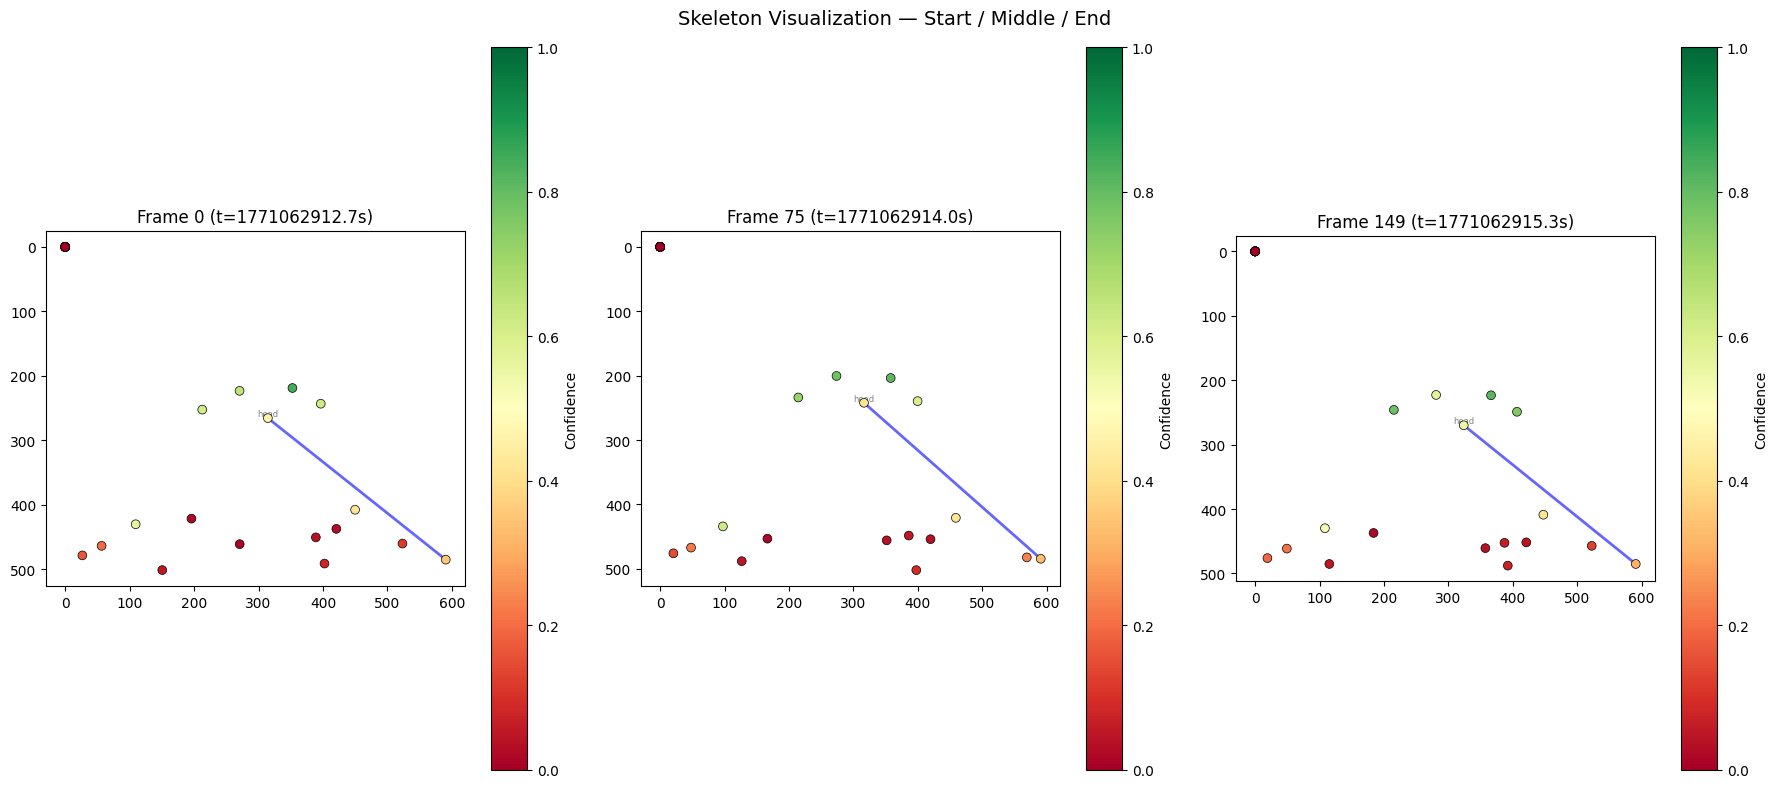

In [7]:
# Visualize a single frame skeleton (2D)
def plot_skeleton_2d(positions_frame, confidences_frame, title="Pose Skeleton", ax=None):
    """Plot a single frame's skeleton in 2D."""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    
    x = positions_frame[:, 0]
    y = positions_frame[:, 1]
    scores = confidences_frame
    
    # Draw connections
    for (i, j) in SKELETON_CONNECTIONS:
        if scores[i] > 0.3 and scores[j] > 0.3:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'b-', linewidth=2, alpha=0.6)
    
    # Draw keypoints (color by confidence)
    scatter = ax.scatter(x, y, c=scores, cmap='RdYlGn', s=40, zorder=5,
                        vmin=0, vmax=1, edgecolors='black', linewidths=0.5)
    
    # Label robot-relevant joints
    for name, idx in ROBOT_KEYPOINTS.items():
        if scores[idx] > 0.3:
            ax.annotate(name, (x[idx], y[idx]), fontsize=6, ha='center',
                       va='bottom', color='gray')
    
    ax.set_title(title)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Image coordinates have y-axis flipped
    plt.colorbar(scatter, ax=ax, label='Confidence')
    return ax

# Plot first, middle, and last frames
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
frame_indices = [0, len(positions)//2, len(positions)-1]
for ax, fi in zip(axes, frame_indices):
    plot_skeleton_2d(positions[fi], confidences[fi],
                    title=f"Frame {fi} (t={timestamps[fi]/1000:.1f}s)", ax=ax)
plt.suptitle("Skeleton Visualization — Start / Middle / End", fontsize=14)
plt.tight_layout()
plt.show()

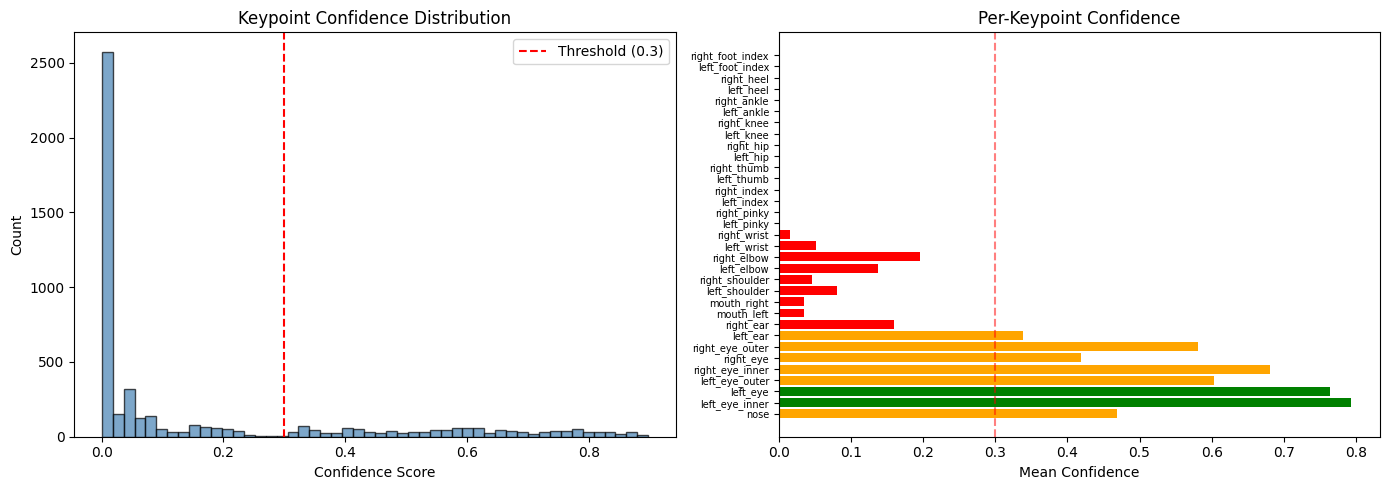

In [8]:
# Confidence distribution across all frames
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall confidence histogram
axes[0].hist(confidences.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.3, color='red', linestyle='--', label='Threshold (0.3)')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Keypoint Confidence Distribution')
axes[0].legend()

# Per-keypoint mean confidence
mean_conf_per_kp = confidences.mean(axis=0)
colors = ['green' if c > 0.7 else 'orange' if c > 0.3 else 'red' for c in mean_conf_per_kp]
axes[1].barh(range(33), mean_conf_per_kp, color=colors)
axes[1].set_yticks(range(33))
axes[1].set_yticklabels(KEYPOINT_NAMES, fontsize=7)
axes[1].set_xlabel('Mean Confidence')
axes[1].set_title('Per-Keypoint Confidence')
axes[1].axvline(x=0.3, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 3. Preprocessing

Before training, we need to:
1. **Filter** low-confidence keypoints
2. **Normalize** positions relative to the body (hip-centered, scale-invariant)
3. **Compute** joint angles and angular velocities
4. **Resample** to uniform timesteps

In [9]:
def preprocess_sequence(positions, confidences, timestamps, confidence_threshold=0.3):
    """
    Preprocess a pose sequence for robot training.
    
    Steps:
    1. Mask low-confidence keypoints
    2. Interpolate missing values
    3. Center on hip midpoint
    4. Normalize by torso length
    
    Returns:
        normalized: (n_frames, 33, 3) normalized positions
    """
    n_frames = positions.shape[0]
    processed = positions.copy()
    
    # Step 1: Mask low-confidence keypoints with NaN
    mask = confidences < confidence_threshold
    for j in range(33):
        for c in range(3):
            processed[mask[:, j], j, c] = np.nan
    
    # Step 2: Interpolate NaN values per keypoint
    for j in range(33):
        for c in range(3):
            series = processed[:, j, c]
            nans = np.isnan(series)
            if nans.all():
                series[:] = 0  # No valid data for this keypoint
            elif nans.any():
                valid_idx = np.where(~nans)[0]
                series[nans] = np.interp(
                    np.where(nans)[0], valid_idx, series[valid_idx]
                )
            processed[:, j, c] = series
    
    # Step 3: Center on hip midpoint
    hip_center = (processed[:, 23, :] + processed[:, 24, :]) / 2  # (n_frames, 3)
    centered = processed - hip_center[:, np.newaxis, :]
    
    # Step 4: Normalize by torso length (shoulder midpoint to hip midpoint)
    shoulder_center = (centered[:, 11, :] + centered[:, 12, :]) / 2
    torso_length = np.linalg.norm(shoulder_center, axis=1).mean()
    if torso_length > 0:
        normalized = centered / torso_length
    else:
        normalized = centered
    
    return normalized


# Preprocess our example
normalized = preprocess_sequence(positions, confidences, timestamps)
print(f"Normalized shape: {normalized.shape}")
print(f"Position range: [{normalized.min():.2f}, {normalized.max():.2f}]")
print(f"Hip center (should be ~0): {normalized[:, 23:25, :].mean(axis=(0,1))}")

Normalized shape: (150, 33, 3)
Position range: [0.00, 595.33]
Hip center (should be ~0): [0. 0. 0.]


In [10]:
def compute_joint_angles(positions):
    """
    Compute joint angles from 3D positions.
    
    Returns angles for key robot joints:
    - Elbow angles (left, right)
    - Shoulder angles (left, right)
    - Knee angles (left, right)
    - Hip angles (left, right)
    """
    def angle_between(v1, v2):
        """Compute angle between two vectors in radians."""
        cos = np.sum(v1 * v2, axis=-1) / (
            np.linalg.norm(v1, axis=-1) * np.linalg.norm(v2, axis=-1) + 1e-8
        )
        return np.arccos(np.clip(cos, -1, 1))
    
    angles = {}
    
    # Left elbow: angle between (shoulder->elbow) and (elbow->wrist)
    v1 = positions[:, 11, :] - positions[:, 13, :]  # shoulder to elbow
    v2 = positions[:, 15, :] - positions[:, 13, :]  # wrist to elbow
    angles['left_elbow'] = angle_between(v1, v2)
    
    # Right elbow
    v1 = positions[:, 12, :] - positions[:, 14, :]
    v2 = positions[:, 16, :] - positions[:, 14, :]
    angles['right_elbow'] = angle_between(v1, v2)
    
    # Left knee: angle between (hip->knee) and (knee->ankle)
    v1 = positions[:, 23, :] - positions[:, 25, :]
    v2 = positions[:, 27, :] - positions[:, 25, :]
    angles['left_knee'] = angle_between(v1, v2)
    
    # Right knee
    v1 = positions[:, 24, :] - positions[:, 26, :]
    v2 = positions[:, 28, :] - positions[:, 26, :]
    angles['right_knee'] = angle_between(v1, v2)
    
    # Left shoulder: angle between (hip->shoulder) and (shoulder->elbow)
    v1 = positions[:, 23, :] - positions[:, 11, :]
    v2 = positions[:, 13, :] - positions[:, 11, :]
    angles['left_shoulder'] = angle_between(v1, v2)
    
    # Right shoulder
    v1 = positions[:, 24, :] - positions[:, 12, :]
    v2 = positions[:, 14, :] - positions[:, 12, :]
    angles['right_shoulder'] = angle_between(v1, v2)
    
    # Left hip: angle between (shoulder->hip) and (hip->knee)
    v1 = positions[:, 11, :] - positions[:, 23, :]
    v2 = positions[:, 25, :] - positions[:, 23, :]
    angles['left_hip'] = angle_between(v1, v2)
    
    # Right hip
    v1 = positions[:, 12, :] - positions[:, 24, :]
    v2 = positions[:, 26, :] - positions[:, 24, :]
    angles['right_hip'] = angle_between(v1, v2)
    
    return angles


def compute_angular_velocities(angles, timestamps):
    """Compute angular velocities (rad/s) via finite differences."""
    dt = np.diff(timestamps) / 1000.0  # Convert ms to seconds
    dt[dt == 0] = 1e-6  # Avoid division by zero
    
    velocities = {}
    for joint, angle_series in angles.items():
        velocities[joint] = np.diff(angle_series) / dt
    
    return velocities


# Compute joint angles and velocities
angles = compute_joint_angles(normalized)
velocities = compute_angular_velocities(angles, timestamps)

print("Joint angle statistics (radians):")
print(f"{'Joint':<20} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 52)
for joint in angles:
    a = angles[joint]
    print(f"{joint:<20} {a.mean():>8.2f} {a.std():>8.2f} {a.min():>8.2f} {a.max():>8.2f}")

Joint angle statistics (radians):
Joint                    Mean      Std      Min      Max
----------------------------------------------------
left_elbow               0.00     0.00     0.00     0.00
right_elbow              1.57     0.00     1.57     1.57
left_knee                1.57     0.00     1.57     1.57
right_knee               1.57     0.00     1.57     1.57
left_shoulder            1.57     0.00     1.57     1.57
right_shoulder           1.57     0.00     1.57     1.57
left_hip                 1.57     0.00     1.57     1.57
right_hip                1.57     0.00     1.57     1.57


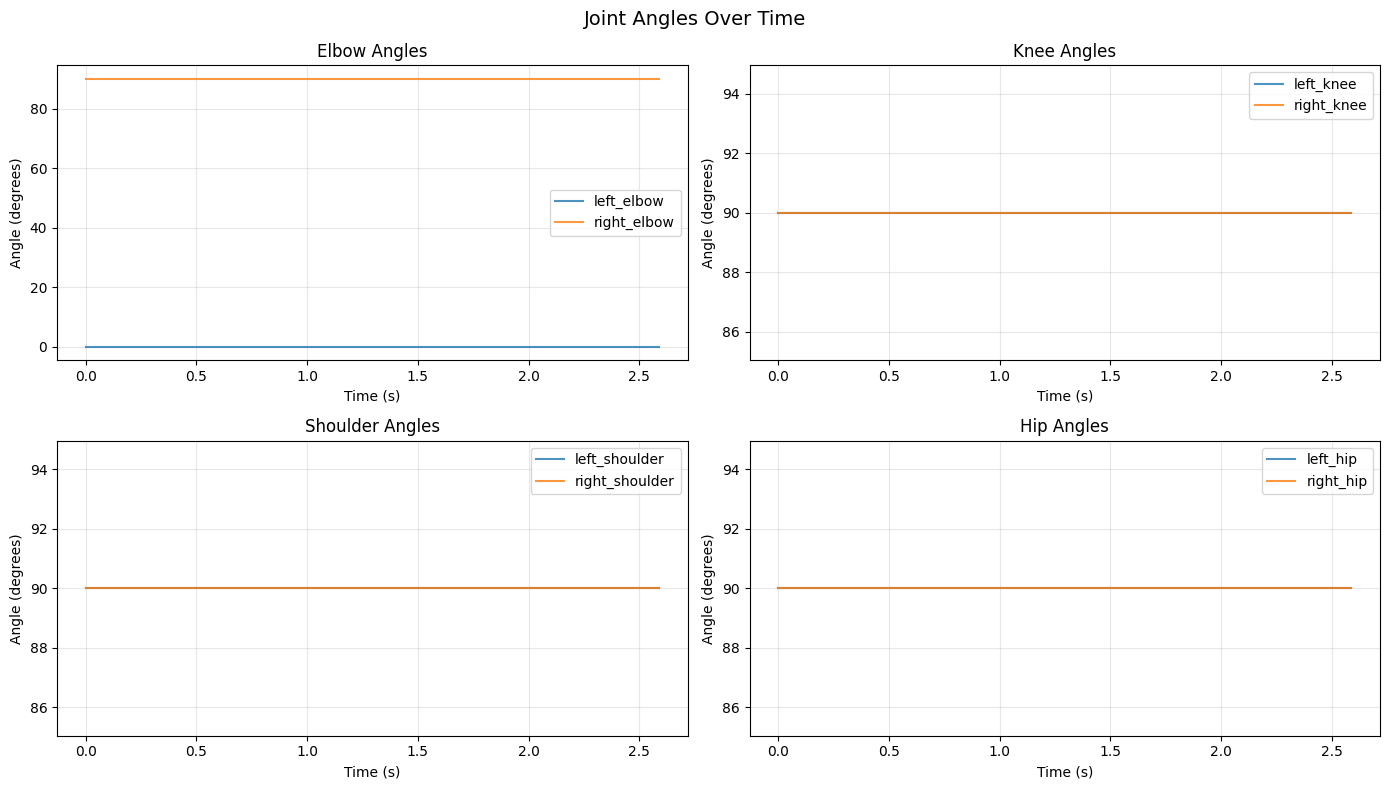

In [11]:
# Plot joint angles over time
time_sec = (timestamps - timestamps[0]) / 1000.0

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
joint_pairs = [
    ('left_elbow', 'right_elbow'),
    ('left_knee', 'right_knee'),
    ('left_shoulder', 'right_shoulder'),
    ('left_hip', 'right_hip'),
]

for ax, (left, right) in zip(axes.flat, joint_pairs):
    ax.plot(time_sec, np.degrees(angles[left]), label=left, alpha=0.8)
    ax.plot(time_sec, np.degrees(angles[right]), label=right, alpha=0.8)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (degrees)')
    ax.set_title(left.replace('left_', '').title() + ' Angles')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Joint Angles Over Time', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Skeleton Animation

Animate the preprocessed skeleton to verify data quality.

In [12]:
def animate_skeleton(positions, confidences, connections, interval=50, max_frames=200):
    """
    Create a 2D animation of the skeleton over time.
    
    Args:
        positions: (n_frames, 33, 3) array
        confidences: (n_frames, 33) array  
        connections: list of (i, j) tuples
        interval: ms between frames
        max_frames: limit frames for performance
    """
    # Subsample if too many frames
    n = min(len(positions), max_frames)
    step = max(1, len(positions) // n)
    pos = positions[::step]
    conf = confidences[::step]
    
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # Initialize plot elements
    lines = []
    for _ in connections:
        line, = ax.plot([], [], 'b-', linewidth=2, alpha=0.6)
        lines.append(line)
    scatter = ax.scatter([], [], c=[], cmap='RdYlGn', s=40, vmin=0, vmax=1,
                        edgecolors='black', linewidths=0.5, zorder=5)
    title = ax.set_title('')
    
    # Set axis limits from data
    all_x = pos[:, :, 0]
    all_y = pos[:, :, 1]
    margin = 0.5
    ax.set_xlim(np.nanmin(all_x) - margin, np.nanmax(all_x) + margin)
    ax.set_ylim(np.nanmax(all_y) + margin, np.nanmin(all_y) - margin)  # inverted
    ax.set_aspect('equal')
    
    def update(frame_idx):
        x = pos[frame_idx, :, 0]
        y = pos[frame_idx, :, 1]
        scores = conf[frame_idx]
        
        # Update connections
        for k, (i, j) in enumerate(connections):
            if scores[i] > 0.3 and scores[j] > 0.3:
                lines[k].set_data([x[i], x[j]], [y[i], y[j]])
                lines[k].set_alpha(0.6)
            else:
                lines[k].set_data([], [])
        
        # Update scatter
        scatter.set_offsets(np.column_stack([x, y]))
        scatter.set_array(scores)
        
        title.set_text(f'Frame {frame_idx * step}/{len(positions)}')
        return lines + [scatter, title]
    
    anim = animation.FuncAnimation(
        fig, update, frames=len(pos), interval=interval, blit=True
    )
    plt.close(fig)
    return anim

# Create animation
anim = animate_skeleton(positions, confidences, SKELETON_CONNECTIONS)
HTML(anim.to_jshtml())

## 5. Model Training — Behavioral Cloning

We train an **LSTM-based behavioral cloning** model that learns to predict the next pose frame given a sequence of previous frames. This is the foundation for **imitation learning** — the robot learns to reproduce human motions.

**Architecture:**
```
Input: (batch, seq_len, n_joints * 3)  →  Joint positions over time
  ↓
LSTM (2 layers, hidden=128)
  ↓
Linear → (batch, n_joints * 3)          →  Next frame prediction
```

In [13]:
class MotionDataset(Dataset):
    """Dataset for motion prediction: given seq_len frames, predict the next frame."""
    
    def __init__(self, sequences, seq_len=30):
        """
        Args:
            sequences: list of (n_frames, n_joints, 3) arrays
            seq_len: number of input frames
        """
        self.samples = []
        self.targets = []
        
        # Use only robot-relevant joints
        joint_indices = list(ROBOT_KEYPOINTS.values())
        
        for seq in sequences:
            # Extract robot joints and flatten to (n_frames, n_joints*3)
            robot_joints = seq[:, joint_indices, :]  # (n_frames, 13, 3)
            flat = robot_joints.reshape(len(seq), -1)  # (n_frames, 39)
            
            # Create sliding window samples
            for i in range(len(flat) - seq_len):
                self.samples.append(flat[i:i+seq_len])
                self.targets.append(flat[i+seq_len])
        
        self.samples = np.array(self.samples, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32)
        
        # Normalize
        self.scaler = StandardScaler()
        flat_samples = self.samples.reshape(-1, self.samples.shape[-1])
        self.scaler.fit(flat_samples)
        
        self.samples = self.scaler.transform(
            self.samples.reshape(-1, self.samples.shape[-1])
        ).reshape(self.samples.shape)
        self.targets = self.scaler.transform(self.targets)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx]),
            torch.tensor(self.targets[idx])
        )


# Build dataset from ALL submissions
all_sequences = []
for sub in submissions:
    pd_raw = sub.get('poseData', [])
    if not pd_raw or len(pd_raw) < 40:  # Need at least seq_len + 10 frames
        continue
    pos, conf, ts = parse_pose_frames(pd_raw)
    norm = preprocess_sequence(pos, conf, ts)
    all_sequences.append(norm)

print(f"Usable sequences: {len(all_sequences)}")
print(f"Total frames: {sum(len(s) for s in all_sequences)}")

# Create dataset
SEQ_LEN = 30  # Use 30 frames (~1 second at 30fps) as context
dataset = MotionDataset(all_sequences, seq_len=SEQ_LEN)
print(f"Training samples: {len(dataset)}")
print(f"Input shape: ({SEQ_LEN}, {dataset.samples.shape[-1]})")
print(f"Target shape: ({dataset.targets.shape[-1]},)")

Usable sequences: 1
Total frames: 150
Training samples: 120
Input shape: (30, 39)
Target shape: (39,)


In [14]:
class MotionPredictor(nn.Module):
    """LSTM-based motion prediction model for behavioral cloning."""
    
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)       # (batch, seq_len, hidden_dim)
        last_hidden = lstm_out[:, -1, :]  # (batch, hidden_dim)
        return self.fc(last_hidden)       # (batch, input_dim)


# Initialize model
INPUT_DIM = dataset.samples.shape[-1]  # 13 joints * 3 coords = 39
model = MotionPredictor(INPUT_DIM, hidden_dim=128, num_layers=2)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")

Model architecture:
MotionPredictor(
  (lstm): LSTM(39, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=39, bias=True)
  )
)

Total parameters: 240,167


In [15]:
# Train/test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {train_size}")
print(f"Test samples: {test_size}")

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()

EPOCHS = 50
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    # Train
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item() * len(batch_x)
    train_loss = epoch_loss / train_size
    train_losses.append(train_loss)
    
    # Evaluate
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            test_loss += criterion(pred, batch_y).item() * len(batch_x)
    test_loss /= test_size
    test_losses.append(test_loss)
    
    scheduler.step(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}  Train Loss: {train_loss:.6f}  Test Loss: {test_loss:.6f}")

print(f"\nFinal — Train: {train_losses[-1]:.6f}, Test: {test_losses[-1]:.6f}")

Train samples: 96
Test samples: 24
Using device: cpu
Epoch 10/50  Train Loss: 0.039363  Test Loss: 0.038391
Epoch 20/50  Train Loss: 0.011968  Test Loss: 0.009409
Epoch 30/50  Train Loss: 0.007488  Test Loss: 0.007637
Epoch 40/50  Train Loss: 0.005333  Test Loss: 0.007264
Epoch 50/50  Train Loss: 0.004526  Test Loss: 0.005737

Final — Train: 0.004526, Test: 0.005737


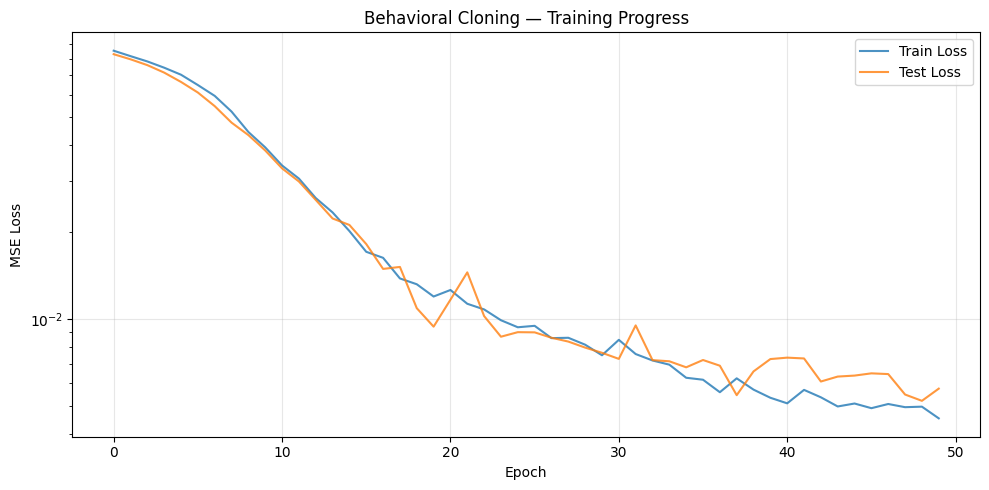

In [16]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', alpha=0.8)
ax.plot(test_losses, label='Test Loss', alpha=0.8)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Behavioral Cloning — Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

## 6. Robot Joint Mapping

Map BlazePose keypoints to humanoid robot joint angles using **inverse kinematics**. This translates human motion data into commands a robot can execute.

### Mapping: BlazePose → Robot Joints

| Robot Joint | DoF | Computed From |
|---|---|---|
| Shoulder Pitch | 1 | shoulder-elbow angle in sagittal plane |
| Shoulder Roll | 1 | shoulder-elbow angle in coronal plane |
| Elbow | 1 | shoulder-elbow-wrist angle |
| Hip Pitch | 1 | hip-knee angle in sagittal plane |
| Hip Roll | 1 | hip-knee angle in coronal plane |
| Knee | 1 | hip-knee-ankle angle |

In [17]:
def compute_robot_joint_commands(positions):
    """
    Convert 3D keypoint positions to robot joint angle commands.
    
    This implements a simplified inverse kinematics mapping from
    BlazePose keypoints to common humanoid robot joint angles.
    
    Returns:
        joint_commands: dict mapping joint names to angle arrays (radians)
    """
    n_frames = len(positions)
    
    def angle_in_plane(v, plane_normal):
        """Project vector onto plane and compute angle from vertical."""
        # Remove component along plane normal
        proj = v - np.outer(np.sum(v * plane_normal, axis=-1), plane_normal)
        # Angle from vertical (y-axis)
        vertical = np.array([0, -1, 0])
        cos = np.sum(proj * vertical, axis=-1) / (np.linalg.norm(proj, axis=-1) + 1e-8)
        return np.arccos(np.clip(cos, -1, 1))
    
    commands = {}
    
    # === ARMS ===
    for side, (s, e, w) in [('left', (11, 13, 15)), ('right', (12, 14, 16))]:
        upper_arm = positions[:, e, :] - positions[:, s, :]  # shoulder to elbow
        forearm = positions[:, w, :] - positions[:, e, :]    # elbow to wrist
        
        # Shoulder pitch (sagittal plane = YZ)
        commands[f'{side}_shoulder_pitch'] = angle_in_plane(
            upper_arm, np.array([1, 0, 0])  # Remove X component
        )
        
        # Shoulder roll (coronal plane = XY)
        commands[f'{side}_shoulder_roll'] = angle_in_plane(
            upper_arm, np.array([0, 0, 1])  # Remove Z component
        )
        
        # Elbow flexion
        cos_elbow = np.sum(-upper_arm * forearm, axis=-1) / (
            np.linalg.norm(upper_arm, axis=-1) * np.linalg.norm(forearm, axis=-1) + 1e-8
        )
        commands[f'{side}_elbow'] = np.arccos(np.clip(cos_elbow, -1, 1))
    
    # === LEGS ===
    for side, (h, k, a) in [('left', (23, 25, 27)), ('right', (24, 26, 28))]:
        thigh = positions[:, k, :] - positions[:, h, :]   # hip to knee
        shin = positions[:, a, :] - positions[:, k, :]    # knee to ankle
        
        # Hip pitch
        commands[f'{side}_hip_pitch'] = angle_in_plane(
            thigh, np.array([1, 0, 0])
        )
        
        # Hip roll
        commands[f'{side}_hip_roll'] = angle_in_plane(
            thigh, np.array([0, 0, 1])
        )
        
        # Knee flexion
        cos_knee = np.sum(-thigh * shin, axis=-1) / (
            np.linalg.norm(thigh, axis=-1) * np.linalg.norm(shin, axis=-1) + 1e-8
        )
        commands[f'{side}_knee'] = np.arccos(np.clip(cos_knee, -1, 1))
    
    return commands


# Compute robot commands from our preprocessed data
robot_commands = compute_robot_joint_commands(normalized)

print("Robot Joint Commands (degrees):")
print(f"{'Joint':<25} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 57)
for joint, angles in robot_commands.items():
    deg = np.degrees(angles)
    print(f"{joint:<25} {deg.mean():>8.1f} {deg.std():>8.1f} {deg.min():>8.1f} {deg.max():>8.1f}")

Robot Joint Commands (degrees):
Joint                         Mean      Std      Min      Max
---------------------------------------------------------
left_shoulder_pitch          180.0      0.0    180.0    180.0
left_shoulder_roll           130.1      0.1    130.0    130.2
left_elbow                     0.0      0.0      0.0      0.0
right_shoulder_pitch          90.0      0.0     90.0     90.0
right_shoulder_roll           90.0      0.0     90.0     90.0
right_elbow                   90.0      0.0     90.0     90.0
left_hip_pitch                90.0      0.0     90.0     90.0
left_hip_roll                 90.0      0.0     90.0     90.0
left_knee                     90.0      0.0     90.0     90.0
right_hip_pitch               90.0      0.0     90.0     90.0
right_hip_roll                90.0      0.0     90.0     90.0
right_knee                    90.0      0.0     90.0     90.0


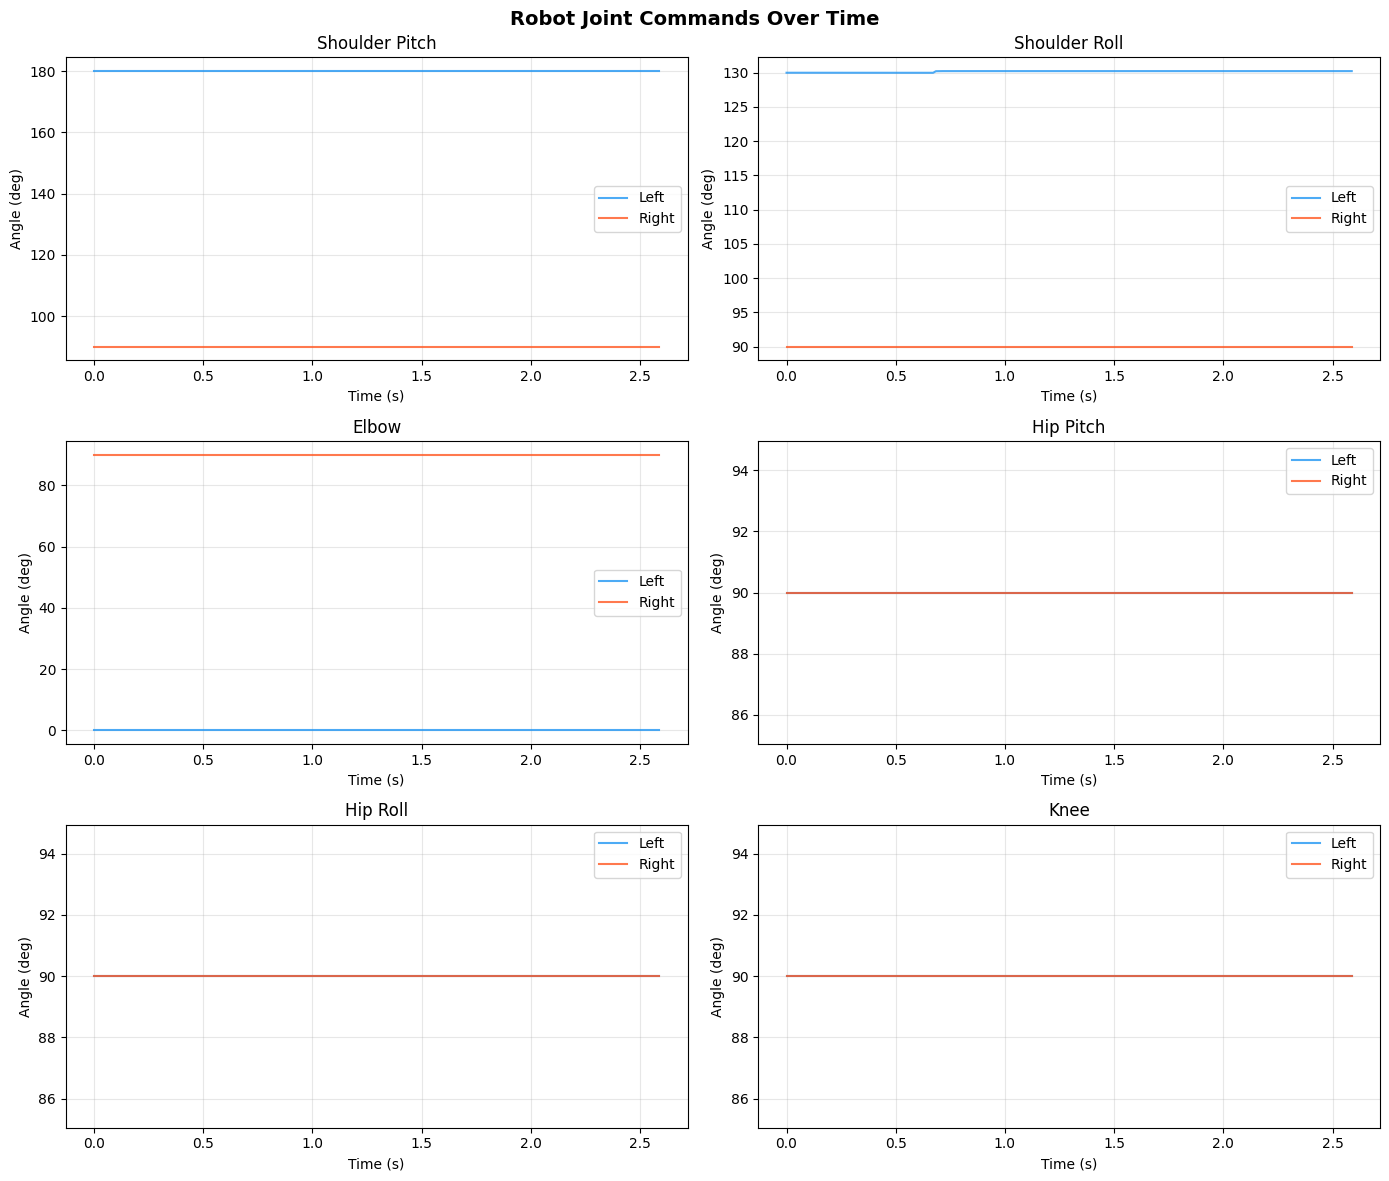

In [18]:
# Visualize robot joint commands over time
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

joint_groups = [
    ('Shoulder Pitch', 'left_shoulder_pitch', 'right_shoulder_pitch'),
    ('Shoulder Roll', 'left_shoulder_roll', 'right_shoulder_roll'),
    ('Elbow', 'left_elbow', 'right_elbow'),
    ('Hip Pitch', 'left_hip_pitch', 'right_hip_pitch'),
    ('Hip Roll', 'left_hip_roll', 'right_hip_roll'),
    ('Knee', 'left_knee', 'right_knee'),
]

for ax, (title, left_key, right_key) in zip(axes.flat, joint_groups):
    ax.plot(time_sec, np.degrees(robot_commands[left_key]),
            label='Left', color='#2196F3', alpha=0.8)
    ax.plot(time_sec, np.degrees(robot_commands[right_key]),
            label='Right', color='#FF5722', alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Angle (deg)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Robot Joint Commands Over Time', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Evaluation — Predicted vs. Actual Trajectories

Evaluate the behavioral cloning model by comparing its **autoregressive predictions** against the ground truth motion.

In [19]:
def autoregressive_predict(model, initial_sequence, n_steps, device, scaler):
    """
    Generate motion by autoregressively feeding predictions back as input.
    
    Args:
        model: trained MotionPredictor
        initial_sequence: (seq_len, n_features) normalized input
        n_steps: number of frames to predict
        device: torch device
        scaler: StandardScaler for normalization
    
    Returns:
        predictions: (n_steps, n_features) predicted frames (original scale)
    """
    model.eval()
    seq = torch.tensor(initial_sequence, dtype=torch.float32).unsqueeze(0).to(device)
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(seq)  # (1, n_features)
            predictions.append(pred.cpu().numpy()[0])
            # Shift window: drop first frame, append prediction
            seq = torch.cat([seq[:, 1:, :], pred.unsqueeze(1)], dim=1)
    
    predictions = np.array(predictions)
    # Inverse transform to original scale
    return scaler.inverse_transform(predictions)


# Take a test sequence and predict the continuation
test_seq_idx = 0
test_sample, test_target = test_dataset[test_seq_idx]

# Get the ground truth continuation (next 60 frames)
PREDICT_STEPS = 60
initial_seq = test_sample.numpy()  # (seq_len, n_features) - already normalized

# Autoregressive prediction
predicted = autoregressive_predict(
    model, initial_seq, PREDICT_STEPS, device, dataset.scaler
)

# Get ground truth for comparison
# (we need to find the original index in the dataset)
gt_start = dataset.scaler.inverse_transform(initial_seq)

print(f"Predicted {PREDICT_STEPS} frames autoregressively")
print(f"Prediction shape: {predicted.shape}")

Predicted 60 frames autoregressively
Prediction shape: (60, 39)


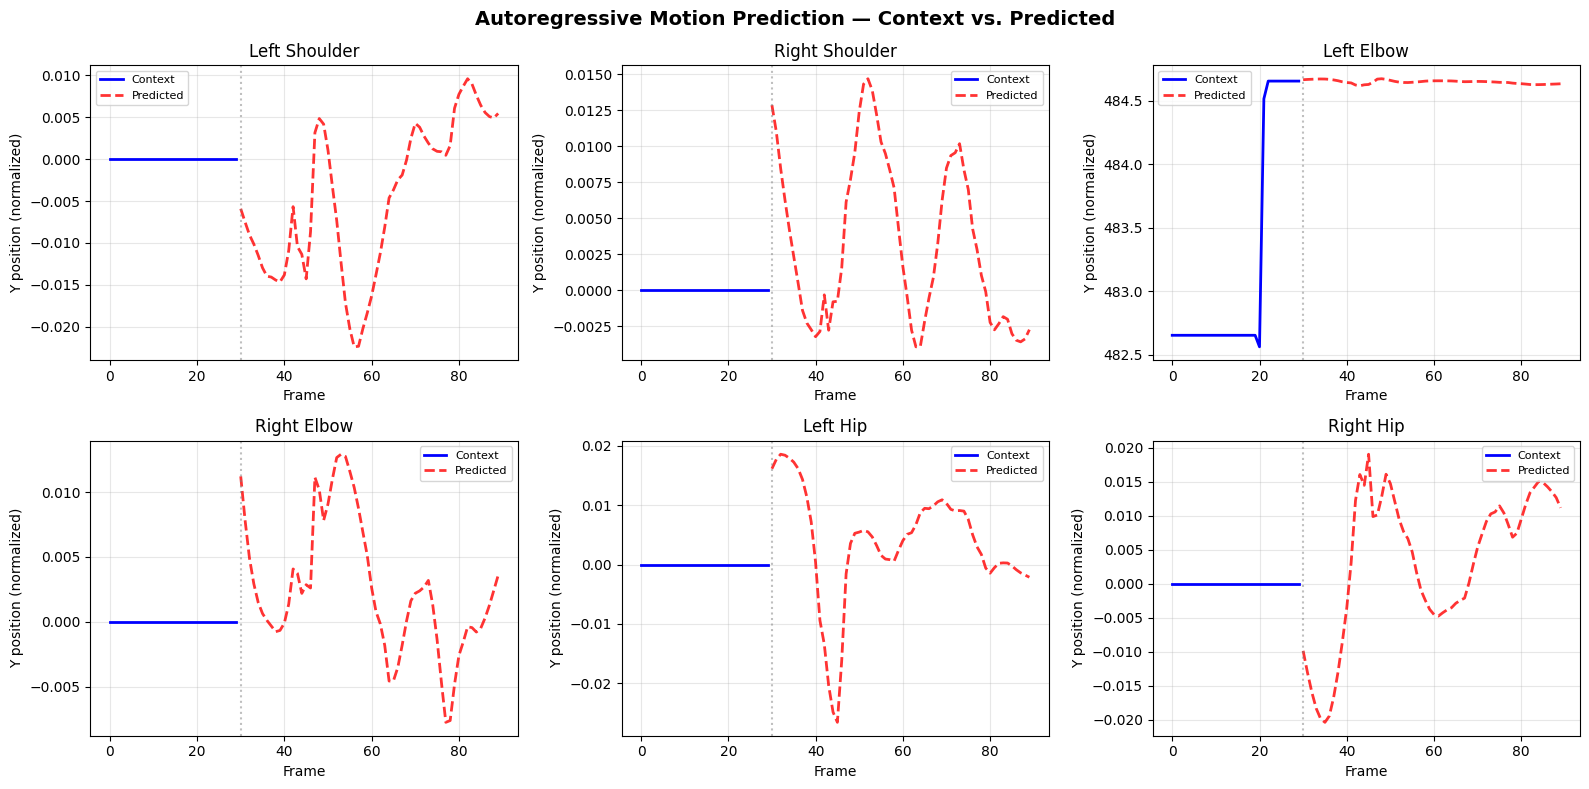

In [20]:
# Compare predicted vs actual joint trajectories
joint_names = list(ROBOT_KEYPOINTS.keys())
n_joints = len(joint_names)

# Plot selected joints
plot_joints = ['left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
               'left_hip', 'right_hip']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ax, joint_name in zip(axes.flat, plot_joints):
    joint_idx = joint_names.index(joint_name)
    # Each joint has 3 coords (x, y, z)
    feat_start = joint_idx * 3
    
    # Plot context (input sequence)
    context_y = gt_start[:, feat_start + 1]  # y-coordinate
    ax.plot(range(SEQ_LEN), context_y, 'b-', linewidth=2, label='Context')
    
    # Plot prediction
    pred_y = predicted[:, feat_start + 1]
    ax.plot(range(SEQ_LEN, SEQ_LEN + PREDICT_STEPS), pred_y,
            'r--', linewidth=2, label='Predicted', alpha=0.8)
    
    ax.axvline(x=SEQ_LEN, color='gray', linestyle=':', alpha=0.5)
    ax.set_title(joint_name.replace('_', ' ').title())
    ax.set_xlabel('Frame')
    ax.set_ylabel('Y position (normalized)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Autoregressive Motion Prediction — Context vs. Predicted',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

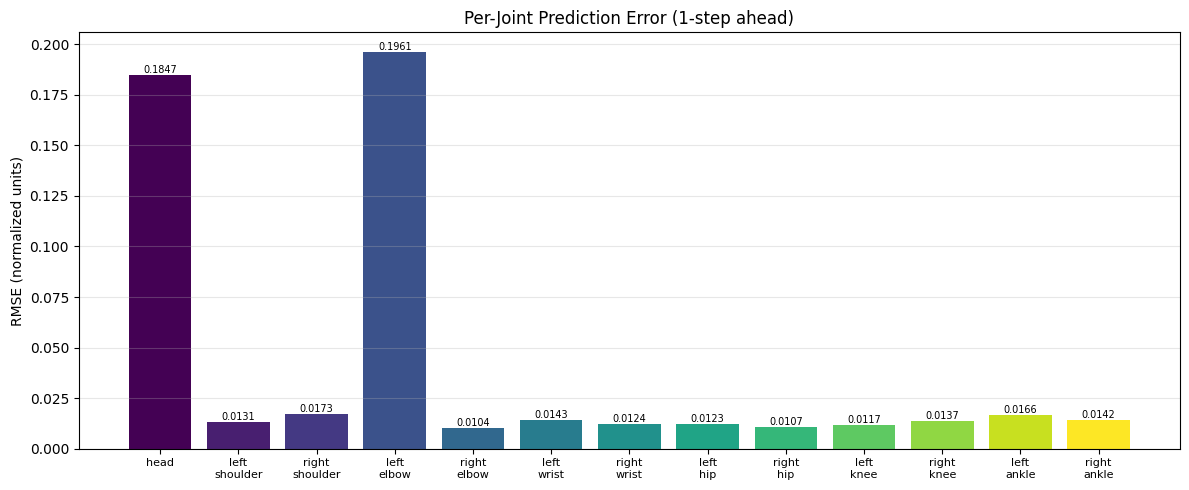


Overall RMSE: 0.075741
Best joint:  right_elbow (RMSE=0.010413)
Worst joint: left_elbow (RMSE=0.196104)


In [21]:
# Per-joint prediction error analysis
model.eval()
all_errors = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        errors = (pred - batch_y).cpu().numpy()
        all_errors.append(errors)

all_errors = np.concatenate(all_errors, axis=0)

# Reshape to (n_samples, n_joints, 3)
errors_per_joint = all_errors.reshape(-1, n_joints, 3)
rmse_per_joint = np.sqrt((errors_per_joint ** 2).mean(axis=(0, 2)))

# Plot per-joint RMSE
fig, ax = plt.subplots(figsize=(12, 5))
colors = plt.cm.viridis(np.linspace(0, 1, n_joints))
bars = ax.bar(range(n_joints), rmse_per_joint, color=colors)
ax.set_xticks(range(n_joints))
ax.set_xticklabels([n.replace('_', '\n') for n in joint_names], fontsize=8)
ax.set_ylabel('RMSE (normalized units)')
ax.set_title('Per-Joint Prediction Error (1-step ahead)')
ax.grid(True, alpha=0.3, axis='y')

# Annotate bars
for bar, rmse in zip(bars, rmse_per_joint):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
            f'{rmse:.4f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

print(f"\nOverall RMSE: {np.sqrt((all_errors ** 2).mean()):.6f}")
print(f"Best joint:  {joint_names[rmse_per_joint.argmin()]} (RMSE={rmse_per_joint.min():.6f})")
print(f"Worst joint: {joint_names[rmse_per_joint.argmax()]} (RMSE={rmse_per_joint.max():.6f})")

## 8. Summary & Next Steps

### What We Built

This notebook demonstrated the complete pipeline for turning **crowdsourced motion capture data** into **humanoid robot training data**:

1. **Data collection** via our web platform (webcam + BlazePose)
2. **Preprocessing** — normalization, joint angle extraction
3. **Behavioral cloning** — LSTM model that learns to predict human motion
4. **Robot mapping** — inverse kinematics from pose keypoints to joint angles

### Scale Advantage

Our platform crowdsources motion data from many contributors, enabling:
- **Diverse motion styles** — different body types and movement patterns
- **Task-specific data** — businesses define exactly what motions they need
- **Quality control** — AI verification + human review ensures clean data
- **Continuous improvement** — new submissions improve the model over time

### Production Extensions

| Extension | Description |
|---|---|
| **Diffusion Policy** | Replace LSTM with diffusion model for multi-modal motion generation |
| **Sim-to-Real** | Train in MuJoCo/Isaac Gym, then transfer to physical robot |
| **Multi-task learning** | Train one model across all task types |
| **Reinforcement Learning** | Fine-tune with reward signals from robot execution |
| **Temporal alignment** | Use DTW to align different-speed performances of the same task |